In [1]:
# Install dependencies if needed
# !pip install scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("claude.csv")

# Severity mapping
severity_mapping = {
    "No Injury": "None",
    "Possible Injury": "Minor",
    "Non Incapacitating Injury": "Minor",
    "Suspected Minor Injury": "Minor",
    "Incapacitating Injury": "Severe",
    "Suspected Serious Injury": "Severe",
    "Fatal": "Severe"
}
df["severity_class"] = df["injury_severity"].map(severity_mapping)

# Binary target: Severe = 1, else 0
df["target"] = (df["severity_class"] == "Severe").astype(int)

# -----------------------------
# 2. Feature selection
# -----------------------------
# Drop columns we shouldn't use (like IDs, raw severity, target, etc.)
drop_cols = ["injury_severity", "severity_class", "target"]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]
y = df["target"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -----------------------------
# 3. Identify categorical vs numeric
# -----------------------------
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# Preprocess: OneHot for categorical, passthrough numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

# -----------------------------
# 4. Logistic Regression
# -----------------------------
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=500))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Extract odds ratios
ohe = log_reg.named_steps["preprocessor"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([cat_features, num_cols])

coefs = log_reg.named_steps["classifier"].coef_[0]
odds_ratios = pd.DataFrame({
    "feature": all_features,
    "odds_ratio": np.exp(coefs)
}).sort_values("odds_ratio", ascending=False)

# Plot odds ratios (top 15)
plt.figure(figsize=(8,6))
sns.barplot(data=odds_ratios.head(15), x="odds_ratio", y="feature", palette="viridis")
plt.title("Top 15 Logistic Regression Odds Ratios (Severe Crash Likelihood)")
plt.xlabel("Odds Ratio (log scale)")
plt.xscale("log")
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Random Forest
# -----------------------------
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=300, random_state=42))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Feature importances
importances = rf.named_steps["classifier"].feature_importances_
feat_importances = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

# Plot top 15
plt.figure(figsize=(8,6))
sns.barplot(data=feat_importances.head(15), x="importance", y="feature", palette="magma")
plt.title("Top 15 Random Forest Feature Importances")
plt.tight_layout()
plt.show()

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 6. PCA Visualization
# -----------------------------

# Encode categorical features (same as before, but output array for PCA)
X_encoded = preprocessor.fit_transform(X)

# Scale features
X_scaled = StandardScaler(with_mean=False).fit_transform(X_encoded)

# PCA to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Build plotting DataFrame
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["severity_ratio"] = y  # 1 = severe, 0 = not severe

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df, 
    x="PC1", y="PC2",
    hue="severity_ratio", 
    palette={0:"skyblue", 1:"darkred"}, 
    alpha=0.6
)
plt.title("PCA of Intersections by Severity Class")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()

In [ ]:
# Install dependencies if needed
# !pip install scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("claude.csv")

# Map severities
severity_mapping = {
    "No Injury": "None",
    "Possible Injury": "Minor",
    "Non Incapacitating Injury": "Minor",
    "Suspected Minor Injury": "Minor",
    "Incapacitating Injury": "Severe",
    "Suspected Serious Injury": "Severe",
    "Fatal": "Severe"
}
df["severity_class"] = df["injury_severity"].map(severity_mapping)

# Binary target
df["target"] = (df["severity_class"] == "Severe").astype(int)

# -----------------------------
# 2. Features & target
# -----------------------------
drop_cols = ["injury_severity", "severity_class", "target"]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]
y = df["target"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -----------------------------
# 3. Preprocessor with Imputation
# -----------------------------
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols)
    ]
)

# -----------------------------
# 4. Logistic Regression
# -----------------------------
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=500))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

# Extract odds ratios
ohe = log_reg.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([cat_features, num_cols])

coefs = log_reg.named_steps["classifier"].coef_[0]
odds_ratios = pd.DataFrame({
    "feature": all_features,
    "odds_ratio": np.exp(coefs)
}).sort_values("odds_ratio", ascending=False)

# Plot odds ratios
plt.figure(figsize=(8,6))
sns.barplot(data=odds_ratios.head(15), x="odds_ratio", y="feature", palette="viridis")
plt.title("Top 15 Logistic Regression Odds Ratios")
plt.xlabel("Odds Ratio (log scale)")
plt.xscale("log")
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Random Forest
# -----------------------------
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=300, random_state=42))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

# Feature importances
importances = rf.named_steps["classifier"].feature_importances_
feat_importances = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(data=feat_importances.head(15), x="importance", y="feature", palette="magma")
plt.title("Top 15 Random Forest Feature Importances")
plt.tight_layout()
plt.show()

# -----------------------------
# 6. PCA Visualization
# -----------------------------
# Full encoded + imputed data
X_encoded = preprocessor.fit_transform(X)

# Scale
X_scaled = StandardScaler(with_mean=False).fit_transform(X_encoded)

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["severity"] = y

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2",
    hue="severity", palette={0:"skyblue", 1:"darkred"},
    alpha=0.6
)
plt.title("PCA Projection by Severity")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title="Severe (1) vs Non-Severe (0)")
plt.tight_layout()
plt.show()

### Correction 3
Tightly bound features <br/>
SMOTE

In [ ]:
# !pip install imbalanced-learn scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("claude.csv")

severity_mapping = {
    "No Injury": "None",
    "Possible Injury": "Minor",
    "Non Incapacitating Injury": "Minor",
    "Suspected Minor Injury": "Minor",
    "Incapacitating Injury": "Severe",
    "Suspected Serious Injury": "Severe",
    "Fatal": "Severe"
}
df["severity_class"] = df["injury_severity"].map(severity_mapping)
df["target"] = (df["severity_class"] == "Severe").astype(int)

# -----------------------------
# 2. Feature selection (drop outcome-like fields)
# -----------------------------
drop_cols = [
    "injury_severity", "severity_class", "target",
    "total_injuries", "total_fatalities", "incident_id", "object_id", "Unnamed: 0"
]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]
y = df["target"]

# -----------------------------
# 3. Train/Test split + SMOTE
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols)
    ]
)

# Encode + SMOTE on training data only
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_enc, y_train)

# Get feature names
ohe = preprocessor.named_transformers_["cat"].named_steps["encoder"]
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([cat_features, num_cols])

# -----------------------------
# 4. Logistic Regression (Balanced)
# -----------------------------
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_bal, y_train_bal)
y_pred_lr = log_reg.predict(X_test_enc)

print("Logistic Regression Report (Balanced + SMOTE):")
print(classification_report(y_test, y_pred_lr))

coefs = log_reg.coef_[0]
odds_ratios = pd.DataFrame({
    "feature": all_features,
    "odds_ratio": np.exp(coefs)
}).sort_values("odds_ratio", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=odds_ratios.head(15), x="odds_ratio", y="feature", palette="viridis")
plt.title("Top 15 Logistic Regression Odds Ratios (Balanced)")
plt.xlabel("Odds Ratio (log scale)")
plt.xscale("log")
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Random Forest (Balanced)
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=300, random_state=42, class_weight="balanced"
)
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test_enc)

print("Random Forest Report (Balanced + SMOTE):")
print(classification_report(y_test, y_pred_rf))

importances = rf.feature_importances_
feat_importances = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=feat_importances.head(15), x="importance", y="feature", palette="magma")
plt.title("Top 15 Random Forest Feature Importances (Balanced)")
plt.tight_layout()
plt.show()

# -----------------------------
# 6. PCA Visualization (Balanced)
# -----------------------------
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_train_bal)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["severity"] = y_train_bal

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2",
    hue="severity", palette={0:"skyblue", 1:"darkred"}, alpha=0.5
)
plt.title("PCA Projection After Balancing")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()

### Better focus on intersection characteristics

#### 1. Aggregate Data

Group by intersection (StreetName + CrossStreet) and compute:

- **Accident volume** → count of crashes.
- **Severity ratio** → % of crashes at that intersection that were "Severe."
- **Contextual features** (average, proportion, or presence):
  - % of alcohol-related crashes at that intersection.
  - % pedestrian-involved crashes.
  - % nighttime crashes.
  - % speeding violations.
  - Average driver age / gender proportions.
  - Road characteristics (if available, e.g., speed limit from OSM).

This gives you one row = one intersection, with descriptive metrics.

In [ ]:
# Map severity
severity_mapping = {
    "No Injury": "None",
    "Possible Injury": "Minor",
    "Non Incapacitating Injury": "Minor",
    "Suspected Minor Injury": "Minor",
    "Incapacitating Injury": "Severe",
    "Suspected Serious Injury": "Severe",
    "Fatal": "Severe"
}
df["severity_class"] = df["injury_severity"].map(severity_mapping)
df["is_severe"] = (df["severity_class"] == "Severe").astype(int)

# Helper flags using both unit_1 and unit_2
def flag_any(row, cols, keyword):
    return int(any(str(row[c]).lower().find(keyword.lower()) >= 0 for c in cols if pd.notna(row[c])))

df["alcohol_flag"] = df.apply(lambda r: flag_any(r, ["alcohol_use_1", "alcohol_use_2"], "yes"), axis=1)
df["drug_flag"]    = df.apply(lambda r: flag_any(r, ["drug_use_1", "drug_use_2"], "yes"), axis=1)
df["ped_flag"]     = df.apply(lambda r: flag_any(r, ["unit_type_1", "unit_type_2"], "pedestrian"), axis=1)
df["bike_flag"]    = df.apply(lambda r: flag_any(r, ["unit_type_1", "unit_type_2"], "pedalcyclist"), axis=1)
df["speed_flag"]   = df.apply(lambda r: flag_any(r, ["violation_1", "violation_2"], "speed"), axis=1)

# Night flag
df["night_flag"] = df["light_condition"].astype(str).str.contains("Dark", case=False, na=False).astype(int)

# Average driver age (take mean of available ages for unit 1 & 2)
df["avg_age_event"] = df[["age_1", "age_2"]].mean(axis=1)

# Aggregate to intersections
intersection_stats = df.groupby(["street_name", "cross_street"]).agg(
    accident_count = ("injury_severity", "count"),
    severe_count   = ("is_severe", "sum"),
    alcohol_pct    = ("alcohol_flag", "mean"),
    drug_pct       = ("drug_flag", "mean"),
    ped_pct        = ("ped_flag", "mean"),
    bike_pct       = ("bike_flag", "mean"),
    night_pct      = ("night_flag", "mean"),
    speed_pct      = ("speed_flag", "mean"),
    avg_age        = ("avg_age_event", "mean")
).reset_index()

# Severity ratio
intersection_stats["severity_ratio"] = (
    intersection_stats["severe_count"] / intersection_stats["accident_count"]
)

# Preview top intersections
print(intersection_stats.sort_values("accident_count", ascending=False).head(10))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("claude.csv")

# Severity mapping
severity_mapping = {
    "No Injury": "None",
    "Possible Injury": "Minor",
    "Non Incapacitating Injury": "Minor",
    "Suspected Minor Injury": "Minor",
    "Incapacitating Injury": "Severe",
    "Suspected Serious Injury": "Severe",
    "Fatal": "Severe"
}
df["severity_class"] = df["injury_severity"].map(severity_mapping)
df["target"] = (df["severity_class"] == "Severe").astype(int)

# -----------------------------
# 2. Features / target
# -----------------------------
drop_cols = ["injury_severity", "severity_class", "target", 
             "total_injuries", "total_fatalities", "incident_id", 
             "object_id", "Unnamed: 0"]

feature_cols = [c for c in df.columns if c not in drop_cols]
X = df[feature_cols]
y = df["target"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -----------------------------
# 3. Preprocessing + SMOTE
# -----------------------------
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols)
    ]
)

# Encode train/test
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

# Apply SMOTE to training set
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_enc, y_train)

# Feature names
ohe = preprocessor.named_transformers_["cat"].named_steps["encoder"]
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([cat_features, num_cols])

# -----------------------------
# 4. Logistic Regression
# -----------------------------
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_bal, y_train_bal)
y_pred_lr = log_reg.predict(X_test_enc)

print("Logistic Regression Report (Crash-Level + SMOTE):")
print(classification_report(y_test, y_pred_lr))

coefs = log_reg.coef_[0]
odds_ratios = pd.DataFrame({
    "feature": all_features,
    "odds_ratio": np.exp(coefs)
}).sort_values("odds_ratio", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=odds_ratios.head(15), x="odds_ratio", y="feature", palette="viridis")
plt.title("Top 15 Logistic Regression Odds Ratios (Severe Crash Likelihood)")
plt.xlabel("Odds Ratio (log scale)")
plt.xscale("log")
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Random Forest
# -----------------------------
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test_enc)

print("Random Forest Report (Crash-Level + SMOTE):")
print(classification_report(y_test, y_pred_rf))

importances = rf.feature_importances_
feat_importances = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=feat_importances.head(15), x="importance", y="feature", palette="magma")
plt.title("Top 15 Random Forest Feature Importances (Severe Crash Likelihood)")
plt.tight_layout()
plt.show()

### Characteristic Research

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
#import caas_jupyter_tools

# ---------- Load & prep crash-level data ----------
df = pd.read_csv("claude.csv")

# Map severity to binary for aggregation
severity_mapping = {
    "No Injury": "None",
    "Possible Injury": "Minor",
    "Non Incapacitating Injury": "Minor",
    "Suspected Minor Injury": "Minor",
    "Incapacitating Injury": "Severe",
    "Suspected Serious Injury": "Severe",
    "Fatal": "Severe"
}
df["severity_class"] = df["injury_severity"].map(severity_mapping)
df["is_severe"] = (df["severity_class"] == "Severe").astype(int)

# Helper flags for INTERSECTION CHARACTERISTICS (not driver demographics)
def flag_any(row, cols, keyword):
    return int(any(str(row[c]).lower().find(keyword.lower()) >= 0 for c in cols if pd.notna(row[c])))

# Impairment / speeding (event-level)
df["alcohol_flag"] = df.apply(lambda r: flag_any(r, ["alcohol_use_1", "alcohol_use_2"], "yes"), axis=1)
df["drug_flag"]    = df.apply(lambda r: flag_any(r, ["drug_use_1", "drug_use_2"], "yes"), axis=1)
df["speed_flag"]   = df.apply(lambda r: flag_any(r, ["violation_1", "violation_2"], "speed"), axis=1)

# Vulnerable users at intersection
df["ped_flag"]     = df.apply(lambda r: flag_any(r, ["unit_type_1", "unit_type_2"], "pedestrian"), axis=1)
df["bike_flag"]    = df.apply(lambda r: flag_any(r, ["unit_type_1", "unit_type_2"], "pedalcyclist"), axis=1)

# Lighting proxy
df["night_flag"]   = df["light_condition"].astype(str).str.contains("Dark", case=False, na=False).astype(int)

# ---------- Aggregate to intersection level ----------
intersection_stats = df.groupby(["street_name", "cross_street"]).agg(
    accident_count=("injury_severity", "count"),
    severe_count=("is_severe", "sum"),
    alcohol_pct=("alcohol_flag", "mean"),
    drug_pct=("drug_flag", "mean"),
    ped_pct=("ped_flag", "mean"),
    bike_pct=("bike_flag", "mean"),
    night_pct=("night_flag", "mean"),
    speed_pct=("speed_flag", "mean"),
).reset_index()

intersection_stats["severity_ratio"] = (
    intersection_stats["severe_count"] / intersection_stats["accident_count"]
)

# Optional: require minimum volume so severity ratios are stable
min_vol = 20
ix = intersection_stats[intersection_stats["accident_count"] >= min_vol].copy()

# ---------- Model: predict severity_ratio from intersection characteristics ----------
feature_cols = ["accident_count", "alcohol_pct", "drug_pct", "ped_pct", "bike_pct", "night_pct", "speed_pct"]
X = ix[feature_cols].values
y = ix["severity_ratio"].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Impute (should be clean, but just in case)
imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_test_i  = imp.transform(X_test)

# RandomForestRegressor for non-linear importance
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    max_depth=None,
    min_samples_leaf=2
)
rf.fit(X_train_i, y_train)

# Permutation importance on test set (more honest than Gini importance)
perm = permutation_importance(rf, X_test_i, y_test, n_repeats=20, random_state=42)

importances = pd.DataFrame({
    "feature": feature_cols,
    "model_importance": rf.feature_importances_,
    "perm_importance_mean": perm.importances_mean,
    "perm_importance_std": perm.importances_std
}).sort_values("perm_importance_mean", ascending=False)

# Also surface the top "dangerous" intersections by residual (actual - predicted)
ix_eval = ix.copy()
ix_eval["pred_sev_ratio"] = rf.predict(imp.transform(ix_eval[feature_cols].values))
ix_eval["residual"] = ix_eval["severity_ratio"] - ix_eval["pred_sev_ratio"]

# Top-10 under-predicted (worse than expected given features): candidates for geometry/signing/speed review
top_under = ix_eval.sort_values("residual", ascending=True).head(10)[
    ["street_name", "cross_street", "accident_count", "severity_ratio", "pred_sev_ratio", "residual"]
]

# Top-10 over-predicted (better than expected): potentially effective designs to replicate
top_over = ix_eval.sort_values("residual", ascending=False).head(10)[
    ["street_name", "cross_street", "accident_count", "severity_ratio", "pred_sev_ratio", "residual"]
]

# Output three tables for the user
display("Intersection severity drivers (permutation importance)", importances)
display("Worse-than-expected intersections (likely geometry/speed issues)", top_under)
display("Better-than-expected intersections (designs worth emulating)", top_over)

'Intersection severity drivers (permutation importance)'

,feature,model_importance,perm_importance_mean,perm_importance_std
3,ped_pct,0.225767,0.083235,0.078325
6,speed_pct,0.193573,0.036792,0.031324
4,bike_pct,0.153381,0.036376,0.031931
0,accident_count,0.221769,0.008294,0.031550
1,alcohol_pct,0.000000,0.000000,0.000000
2,drug_pct,0.000000,0.000000,0.000000
5,night_pct,0.205510,-0.002905,0.035188


'Worse-than-expected intersections (likely geometry/speed issues)'

,street_name,cross_street,accident_count,severity_ratio,pred_sev_ratio,residual
2943,University Dr,Maple Ave,48,0.0,0.051054,-0.051054
38,13th St,Mill Ave,24,0.0,0.049827,-0.049827
3073,Warner Rd,Los Feliz Dr,26,0.0,0.041154,-0.041154
877,Darrow Dr,Priest Dr,21,0.0,0.036607,-0.036607
2945,University Dr,May St,22,0.0,0.035458,-0.035458
164,52nd St,Broadway Rd,43,0.0,0.034865,-0.034865
2326,Priest Dr,Arizona Mills Conn,25,0.0,0.034464,-0.034464
2891,Terrace Rd,Lemon St,46,0.0,0.033480,-0.033480
3053,Warner Rd,Emerald Dr,26,0.0,0.029699,-0.029699
1032,Elliot Rd,McClintock Dr,154,0.0,0.028108,-0.028108


'Better-than-expected intersections (designs worth emulating)'

,street_name,cross_street,accident_count,severity_ratio,pred_sev_ratio,residual
151,48th St,Westcourt Way,48,0.125000,0.010875,0.114125
2565,Rural Rd,Divot Dr,25,0.080000,0.008848,0.071152
1010,Elliot Rd,Country Club Way,34,0.088235,0.020715,0.067520
2940,University Dr,Lindon Ln,30,0.100000,0.035554,0.064446
2687,Scottsdale Rd,Fillmore St,22,0.090909,0.030111,0.060798
2426,Rio Salado Pkwy,Price NB Rd,35,0.085714,0.031834,0.053880
854,Curry Rd,College Ave,47,0.127660,0.074977,0.052682
2767,Southern Ave,Clementine Dr,47,0.063830,0.012744,0.051086
2062,Mill Ave,Ellis Dr,26,0.115385,0.067457,0.047928
1956,Mcclintock Dr,Apache Blvd,54,0.055556,0.007982,0.047574


In [11]:
# pip install osmnx geopandas shapely

import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# -----------------------------
# 1. Define intersections
# -----------------------------
sites = {
    "University Dr & Maple Ave, Tempe, AZ": (33.42162, -111.93865),  # approximate coords
    "48th St & Westcourt Way, Tempe, AZ":   (33.40353, -111.97916)   # approximate coords
}

# -----------------------------
# 2. Download street network
# -----------------------------
G = ox.graph_from_place("Tempe, Arizona, USA", network_type="drive")
nodes, edges = ox.graph_to_gdfs(G)

# -----------------------------
# 3. Helper to analyze intersection
# -----------------------------
def analyze_intersection(name, coords):
    point = Point(coords[1], coords[0])  # lon, lat
    # Snap to nearest node in graph
    nearest_node = ox.distance.nearest_nodes(G, coords[1], coords[0])
    
    # Get neighbors (connected edges)
    neighbors = list(G.neighbors(nearest_node))
    
    # Compute metrics
    n_approaches = len(neighbors)
    angles = []
    speeds = []
    widths = []
    
    for nbr in neighbors:
        edge_data = G.get_edge_data(nearest_node, nbr)[0]
        if "geometry" in edge_data:
            line = edge_data["geometry"]
            dx = line.coords[-1][0] - line.coords[0][0]
            dy = line.coords[-1][1] - line.coords[0][1]
            angle = np.degrees(np.arctan2(dy, dx)) % 180
            angles.append(angle)
        if "maxspeed" in edge_data:
            try:
                val = edge_data["maxspeed"]
                if isinstance(val, list): val = val[0]
                speeds.append(int(str(val).split()[0]))
            except:
                pass
        if "width" in edge_data:
            try:
                widths.append(float(edge_data["width"]))
            except:
                pass
    
    return {
        "intersection": name,
        "node_id": nearest_node,
        "approaches": n_approaches,
        "mean_angle": np.mean(angles) if angles else None,
        "speed_limits": speeds,
        "avg_speed": np.mean(speeds) if speeds else None,
        "avg_width": np.mean(widths) if widths else None
    }

# -----------------------------
# 4. Run comparison
# -----------------------------
results = []
for name, coords in sites.items():
    results.append(analyze_intersection(name, coords))

comparison = pd.DataFrame(results)
print(comparison)

                           intersection     node_id  approaches  mean_angle  \
0  University Dr & Maple Ave, Tempe, AZ  1698683885           2   45.692732   
1    48th St & Westcourt Way, Tempe, AZ  7276025850           3   47.934055   

  speed_limits  avg_speed avg_width  
0     [35, 15]       25.0      None  
1     [45, 45]       45.0      None  


In [9]:
# Install dependencies if not already installed:
# pip install osmnx geopandas shapely

import pandas as pd
import numpy as np
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# -----------------------------
# 1. Load crash dataset
# -----------------------------
df = pd.read_csv("claude.csv")

# Severity mapping
severity_mapping = {
    "No Injury": "None",
    "Possible Injury": "Minor",
    "Non Incapacitating Injury": "Minor",
    "Suspected Minor Injury": "Minor",
    "Incapacitating Injury": "Severe",
    "Suspected Serious Injury": "Severe",
    "Fatal": "Severe"
}
df["severity_class"] = df["injury_severity"].map(severity_mapping)
df["is_severe"] = (df["severity_class"] == "Severe").astype(int)

# -----------------------------
# 2. Flags (intersection-level risk mix)
# -----------------------------
def flag_any(row, cols, keyword):
    return int(any(str(row[c]).lower().find(keyword.lower()) >= 0 for c in cols if pd.notna(row[c])))

df["alcohol_flag"] = df.apply(lambda r: flag_any(r, ["alcohol_use_1", "alcohol_use_2"], "yes"), axis=1)
df["drug_flag"]    = df.apply(lambda r: flag_any(r, ["drug_use_1", "drug_use_2"], "yes"), axis=1)
df["speed_flag"]   = df.apply(lambda r: flag_any(r, ["violation_1", "violation_2"], "speed"), axis=1)
df["ped_flag"]     = df.apply(lambda r: flag_any(r, ["unit_type_1", "unit_type_2"], "pedestrian"), axis=1)
df["bike_flag"]    = df.apply(lambda r: flag_any(r, ["unit_type_1", "unit_type_2"], "pedalcyclist"), axis=1)
df["night_flag"]   = df["light_condition"].astype(str).str.contains("Dark", case=False, na=False).astype(int)

# -----------------------------
# 3. Aggregate to intersection-level
# -----------------------------
intersection_stats = df.groupby(["street_name", "cross_street"]).agg(
    accident_count=("injury_severity", "count"),
    severe_count=("is_severe", "sum"),
    alcohol_pct=("alcohol_flag", "mean"),
    drug_pct=("drug_flag", "mean"),
    ped_pct=("ped_flag", "mean"),
    bike_pct=("bike_flag", "mean"),
    night_pct=("night_flag", "mean"),
    speed_pct=("speed_flag", "mean"),
    lat=("lat", "mean"),
    long=("long", "mean")
).reset_index()

intersection_stats["severity_ratio"] = (
    intersection_stats["severe_count"] / intersection_stats["accident_count"]
)

# Require minimum volume for stability
min_vol = 20
ix = intersection_stats[intersection_stats["accident_count"] >= min_vol].copy()

# -----------------------------
# 4. Pull posted speed limits from OSM
# -----------------------------
G = ox.graph_from_place("Tempe, Arizona, USA", network_type="drive")
edges = ox.graph_to_gdfs(G, nodes=False)

# Parse maxspeed field
def parse_speed(val):
    try:
        if isinstance(val, list): val = val[0]
        return int(str(val).split()[0])
    except:
        return np.nan

edges["maxspeed_num"] = edges["maxspeed"].apply(parse_speed)

# Intersections as GeoDataFrame
ix_gdf = gpd.GeoDataFrame(
    ix,
    geometry=[Point(xy) for xy in zip(ix["long"], ix["lat"])],
    crs="EPSG:4326"
)

# Spatial join to nearest edge
edges = edges.dropna(subset=["maxspeed_num"])
joined = gpd.sjoin_nearest(ix_gdf, edges[["maxspeed_num", "geometry"]], how="left")

# Add posted speed features
ix["avg_posted_speed"] = joined.groupby(joined.index)["maxspeed_num"].mean()
ix["max_posted_speed"] = joined.groupby(joined.index)["maxspeed_num"].max()

# -----------------------------
# 5. Model severity ratio with RandomForestRegressor
# -----------------------------
feature_cols = ["accident_count", "alcohol_pct", "drug_pct", "ped_pct", 
                "bike_pct", "night_pct", "speed_pct", 
                "avg_posted_speed", "max_posted_speed"]

X = ix[feature_cols].values
y = ix["severity_ratio"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_test_i  = imp.transform(X_test)

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    max_depth=None,
    min_samples_leaf=2
)
rf.fit(X_train_i, y_train)

# Permutation importance
perm = permutation_importance(rf, X_test_i, y_test, n_repeats=20, random_state=42)

importances = pd.DataFrame({
    "feature": feature_cols,
    "model_importance": rf.feature_importances_,
    "perm_importance_mean": perm.importances_mean,
    "perm_importance_std": perm.importances_std
}).sort_values("perm_importance_mean", ascending=False)

# -----------------------------
# 6. Residual analysis
# -----------------------------
ix_eval = ix.copy()
ix_eval["pred_sev_ratio"] = rf.predict(imp.transform(ix_eval[feature_cols].values))
ix_eval["residual"] = ix_eval["severity_ratio"] - ix_eval["pred_sev_ratio"]

# Worst offenders (worse than expected given risk factors + speed limits)
top_under = ix_eval.sort_values("residual", ascending=True).head(10)[
    ["street_name", "cross_street", "accident_count", "severity_ratio", "pred_sev_ratio", "residual"]
]

# Better than expected (design strengths)
top_over = ix_eval.sort_values("residual", ascending=False).head(10)[
    ["street_name", "cross_street", "accident_count", "severity_ratio", "pred_sev_ratio", "residual"]
]

# -----------------------------
# 7. Outputs
# -----------------------------
display("Intersection severity drivers (with posted speeds)", importances)
display("Worse-than-expected intersections (likely geometry/sight/signal issues)", top_under)
display("Better-than-expected intersections (designs worth emulating)", top_over)

/Users/joshuadollison/miniforge3/envs/py312/lib/python3.12/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


'Intersection severity drivers (with posted speeds)'

,feature,model_importance,perm_importance_mean,perm_importance_std
3,ped_pct,0.221782,0.063167,0.081890
6,speed_pct,0.175691,0.054892,0.029192
4,bike_pct,0.133864,0.034043,0.028543
0,accident_count,0.211742,0.022229,0.031745
8,max_posted_speed,0.040502,0.011676,0.013525
7,avg_posted_speed,0.039504,0.008102,0.014199
1,alcohol_pct,0.000000,0.000000,0.000000
2,drug_pct,0.000000,0.000000,0.000000
5,night_pct,0.176913,-0.007877,0.029707


'Worse-than-expected intersections (likely geometry/sight/signal issues)'

,street_name,cross_street,accident_count,severity_ratio,pred_sev_ratio,residual
2943,University Dr,Maple Ave,48,0.0,0.054124,-0.054124
38,13th St,Mill Ave,24,0.0,0.047488,-0.047488
2945,University Dr,May St,22,0.0,0.035940,-0.035940
2891,Terrace Rd,Lemon St,46,0.0,0.035389,-0.035389
2326,Priest Dr,Arizona Mills Conn,25,0.0,0.033888,-0.033888
164,52nd St,Broadway Rd,43,0.0,0.032087,-0.032087
2937,University Dr,Hacienda Dr,33,0.0,0.030833,-0.030833
554,Broadway Rd,I-10 Exit 153 P-Ramp,32,0.0,0.030329,-0.030329
365,Arizona Mills S,Baseline Rd,20,0.0,0.029720,-0.029720
221,6th St,Mill Ave,40,0.0,0.028981,-0.028981


'Better-than-expected intersections (designs worth emulating)'

,street_name,cross_street,accident_count,severity_ratio,pred_sev_ratio,residual
151,48th St,Westcourt Way,48,0.125000,0.012610,0.112390
2687,Scottsdale Rd,Fillmore St,22,0.090909,0.015767,0.075142
2565,Rural Rd,Divot Dr,25,0.080000,0.014730,0.065270
2940,University Dr,Lindon Ln,30,0.100000,0.035168,0.064832
1010,Elliot Rd,Country Club Way,34,0.088235,0.024527,0.063708
854,Curry Rd,College Ave,47,0.127660,0.076193,0.051466
2426,Rio Salado Pkwy,Price NB Rd,35,0.085714,0.034595,0.051119
2767,Southern Ave,Clementine Dr,47,0.063830,0.013690,0.050140
1956,Mcclintock Dr,Apache Blvd,54,0.055556,0.007896,0.047660
2062,Mill Ave,Ellis Dr,26,0.115385,0.067737,0.047647


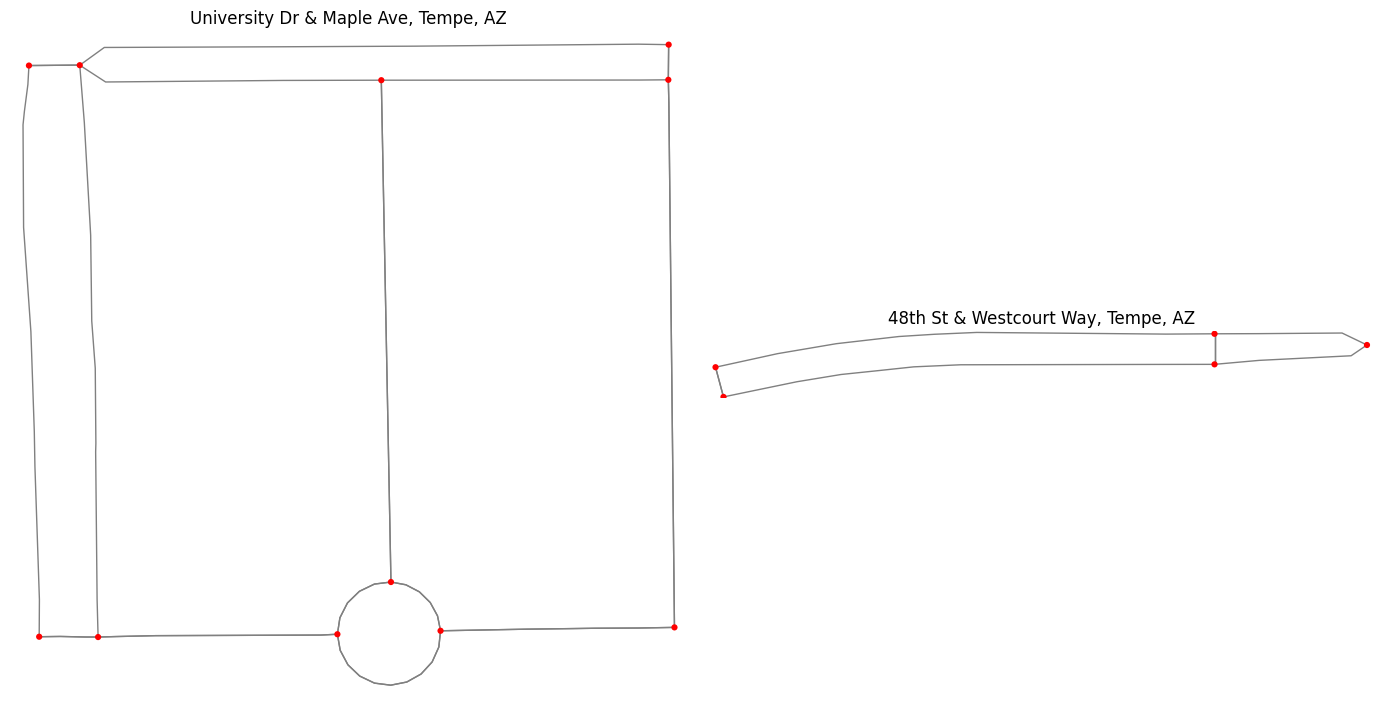

In [10]:
import matplotlib.pyplot as plt
import osmnx as ox

# Define intersections (lat, lon)
sites = {
    "University Dr & Maple Ave, Tempe, AZ": (33.42162, -111.93865),
    "48th St & Westcourt Way, Tempe, AZ":   (33.40353, -111.97916)
}

# Download Tempe graph
G = ox.graph_from_place("Tempe, Arizona, USA", network_type="drive")

# Plot each intersection
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

for ax, (name, coords) in zip(axes, sites.items()):
    # Get subgraph within 150m of point
    subgraph = ox.graph_from_point(coords, dist=150, network_type="drive")
    
    # Plot
    ox.plot_graph(subgraph, ax=ax, node_size=20, node_color="red",
                  edge_color="gray", edge_linewidth=1, show=False, close=False)
    ax.set_title(name, fontsize=12)

plt.tight_layout()
plt.show()


[Sample of geometry+stats for focus intersections]
   street_name      cross_street  group  accident_count  severity_ratio  \
0      48th St     Westcourt Way  LV_HS              48        0.125000   
1       5th St        Myrtle Ave  LV_HS              11        0.090909   
2       5th St          Price Rd  LV_HS              10        0.100000   
3  Apache Blvd           13th St  LV_HS              12        0.250000   
4  Apache Blvd          Mill Ave  LV_HS              13        0.076923   
5  Apache Blvd            Oak St  LV_HS              11        0.090909   
6  Apache Blvd   Paseo Del Saber  LV_HS              10        0.100000   
7  Apache Blvd          Rural Rd  HV_LS             262        0.007634   
8  Baseline Rd           48th St  HV_LS             250        0.004000   
9  Baseline Rd  Calle Los Cerros  HV_LS             279        0.003584   

   n_approaches  min_angle_gap  avg_lanes  max_lanes  avg_posted_speed  \
0             3      86.064057   5.000000       

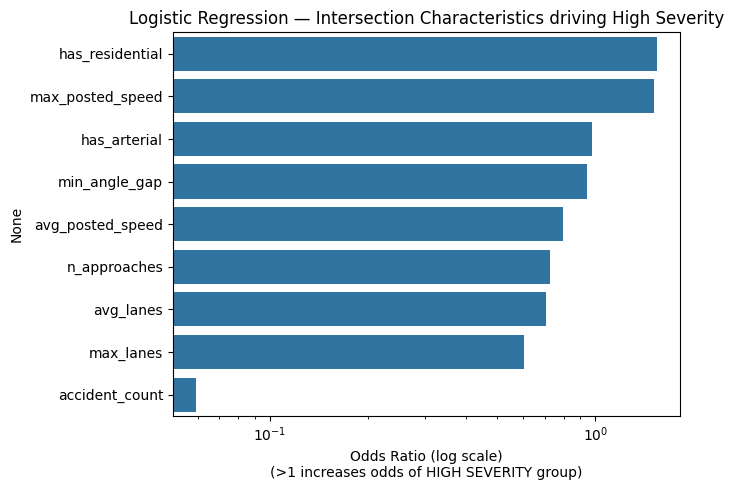

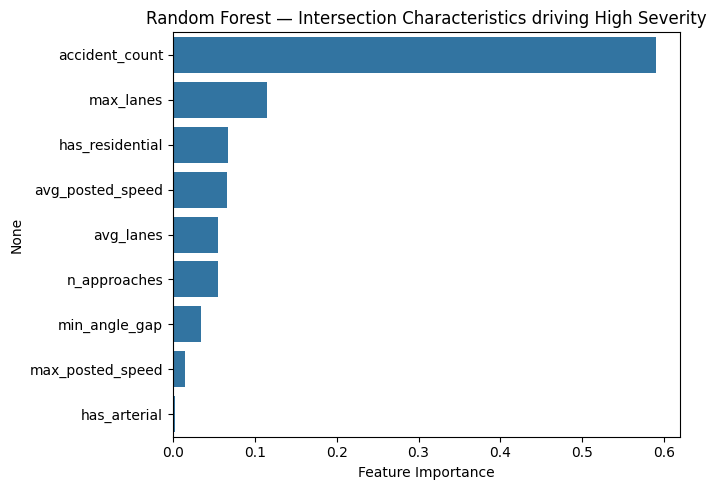


=== Group Profiles (means) ===


,accident_count,n_approaches,min_angle_gap,avg_lanes,max_lanes,avg_posted_speed,max_posted_speed,has_arterial,has_residential,severity_ratio
group,,,,,,,,,,
HV_LS,283.26,3.92,45.075,5.157,6.347,38.120,39.348,0.98,0.14,0.016
HV_HS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LV_HS,18.58,3.34,45.546,3.738,4.240,30.888,34.348,0.84,0.62,0.114


In [13]:
# pip install osmnx geopandas shapely scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 0) CONFIG / COLUMN NAMES
# -----------------------------
CSV_PATH = "claude.csv"
COLS = dict(
    street="street_name",
    cross="cross_street",
    lat="lat",
    lon="long",
    severity_raw="injury_severity",
)

CITY = "Tempe, Arizona, USA"
MIN_VOL = 10    # minimum crashes at an intersection to keep (stability for severity%)
TOP_N  = 50     # top-N by volume and by severity%

# -----------------------------
# 1) LOAD & BUILD INTERSECTION STATS (volume + severity%)
# -----------------------------
df = pd.read_csv(CSV_PATH)

severity_map = {
    "No Injury": "None",
    "Possible Injury": "Minor",
    "Non Incapacitating Injury": "Minor",
    "Suspected Minor Injury": "Minor",
    "Incapacitating Injury": "Severe",
    "Suspected Serious Injury": "Severe",
    "Fatal": "Severe",
}
df["severity_class"] = df[COLS["severity_raw"]].map(severity_map)
df["is_severe"] = (df["severity_class"] == "Severe").astype(int)

intersections = (
    df.groupby([COLS["street"], COLS["cross"]])
      .agg(accident_count=(COLS["severity_raw"], "count"),
           severe_count=("is_severe", "sum"),
           lat=(COLS["lat"], "mean"),
           lon=(COLS["lon"], "mean"))
      .reset_index()
)
intersections["severity_ratio"] = intersections["severe_count"] / intersections["accident_count"]
intersections = intersections.dropna(subset=["lat","lon"])
intersections = intersections[intersections["accident_count"] >= MIN_VOL].copy()

# -----------------------------
# 2) SELECT TOP-50s + LABEL GROUPS
# -----------------------------
top_vol_idx = intersections.nlargest(TOP_N, "accident_count").set_index([COLS["street"], COLS["cross"]]).index
top_sev_idx = intersections.nlargest(TOP_N, "severity_ratio").set_index([COLS["street"], COLS["cross"]]).index

def group_label(row):
    key = (row[COLS["street"]], row[COLS["cross"]])
    in_vol = key in top_vol_idx
    in_sev = key in top_sev_idx
    if in_vol and not in_sev:
        return "HV_LS"  # High Volume / Low Severity
    elif in_vol and in_sev:
        return "HV_HS"  # High Volume / High Severity
    elif (not in_vol) and in_sev:
        return "LV_HS"  # Low Volume / High Severity
    else:
        return np.nan

intersections["group"] = intersections.apply(group_label, axis=1)
focus = intersections.dropna(subset=["group"]).copy()

# -----------------------------
# 3) OSMNX: BUILD GEOMETRY + SPEED FEATURES FOR FOCUS INTERSECTIONS
# -----------------------------
G = ox.graph_from_place(CITY, network_type="drive")
nodes, edges = ox.graph_to_gdfs(G)

# ensure bearings attribute for geometry angles
G = ox.bearing.add_edge_bearings(G)

def parse_speed(val):
    try:
        if isinstance(val, list): val = val[0]
        return int(str(val).split()[0])
    except:
        return np.nan

def parse_lanes(val):
    try:
        if isinstance(val, list): val = val[0]
        return float(str(val).split(";")[0])
    except:
        return np.nan

def node_geometry_features(lat, lon):
    node = ox.distance.nearest_nodes(G, lon, lat)
    # neighbors and incident edges
    neighbors = list(G.successors(node)) + list(G.predecessors(node))
    neighbors = list(set(neighbors))
    n_approaches = len(neighbors)

    bearings = []
    speeds = []
    lanes = []
    highway_types = []

    for nbr in neighbors:
        # get all parallel edges; use first
        data = list(G.get_edge_data(node, nbr, default={}).values())
        if not data:
            data = list(G.get_edge_data(nbr, node, default={}).values())
        if not data:
            continue
        ed = data[0]
        # bearing
        if "bearing" in ed:
            bearings.append(ed["bearing"])
        # speed
        if "maxspeed" in ed:
            s = parse_speed(ed["maxspeed"])
            if not np.isnan(s):
                speeds.append(s)
        # lanes
        if "lanes" in ed:
            l = parse_lanes(ed["lanes"])
            if not np.isnan(l):
                lanes.append(l)
        # highway class
        if "highway" in ed:
            if isinstance(ed["highway"], list):
                highway_types += ed["highway"]
            else:
                highway_types.append(ed["highway"])

    # angle spread: min pairwise angular separation (conflict potential)
    min_angle_gap = None
    if len(bearings) >= 2:
        b_sorted = sorted([(b % 360) for b in bearings])
        diffs = np.diff(b_sorted + [b_sorted[0] + 360])
        min_angle_gap = float(np.min(diffs))

    # flags for arterial presence
    arterial_flag = int(any(ht in {"primary","secondary","trunk"} for ht in highway_types))
    residential_flag = int(any(ht in {"residential"} for ht in highway_types))

    feats = dict(
        n_approaches=n_approaches,
        min_angle_gap=min_angle_gap,                 # smaller gap = more skew
        avg_lanes=np.nanmean(lanes) if lanes else np.nan,
        max_lanes=np.nanmax(lanes) if lanes else np.nan,
        avg_posted_speed=np.nanmean(speeds) if speeds else np.nan,
        max_posted_speed=np.nanmax(speeds) if speeds else np.nan,
        has_arterial=arterial_flag,
        has_residential=residential_flag,
    )
    return feats

geo_rows = []
for _, r in focus.iterrows():
    feats = node_geometry_features(r["lat"], r["lon"])
    feats.update({COLS["street"]: r[COLS["street"]], COLS["cross"]: r[COLS["cross"]]})
    geo_rows.append(feats)

geom_df = pd.DataFrame(geo_rows)

# -----------------------------
# 4) MERGE GEOMETRY WITH FOCUS SET
# -----------------------------
Xdf = focus.merge(geom_df, on=[COLS["street"], COLS["cross"]], how="left")

# drop rows with no geometry matched
Xdf = Xdf.dropna(subset=["n_approaches"])

# features strictly about intersection/site (NO driver demographics)
feature_cols = [
    "accident_count",
    "severity_ratio",
    "n_approaches",
    "min_angle_gap",
    "avg_lanes", "max_lanes",
    "avg_posted_speed", "max_posted_speed",
    "has_arterial", "has_residential",
]
summary_cols = [COLS["street"], COLS["cross"], "group"] + feature_cols
print("\n[Sample of geometry+stats for focus intersections]")
print(Xdf[summary_cols].head(10))

# -----------------------------
# 5) ML: WHAT DISTINGUISHES HIGH-SEVERITY GROUPS?
#    Target = HS (1) if group in {HV_HS, LV_HS}; else 0 (HV_LS)
# -----------------------------
Xdf["HS_flag"] = Xdf["group"].isin(["HV_HS","LV_HS"]).astype(int)

# model features (exclude severity_ratio to avoid target leakage in classification)
model_features = [
    "accident_count",
    "n_approaches",
    "min_angle_gap",
    "avg_lanes", "max_lanes",
    "avg_posted_speed", "max_posted_speed",
    "has_arterial", "has_residential",
]

X = Xdf[model_features].copy()
y = Xdf["HS_flag"].copy()

# impute + scale for logistic; forest doesn't need scaling but it's fine
imputer = SimpleImputer(strategy="median")
scaler  = StandardScaler()

X_imp = imputer.fit_transform(X)
X_scl = scaler.fit_transform(X_imp)

X_train, X_test, y_train, y_test = train_test_split(
    X_scl, y, test_size=0.3, random_state=42, stratify=y
)

# LOGISTIC REGRESSION (balanced)
logreg = LogisticRegression(max_iter=1000, class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
print("\n=== Logistic Regression (HS vs HV_LS) ===")
print(classification_report(y_test, y_pred_lr, digits=3))

# Odds ratios
odds = pd.Series(np.exp(logreg.coef_[0]), index=model_features).sort_values(ascending=False)
print("\n[Logistic Regression Odds Ratios]\n", odds)

# RANDOM FOREST
rf = RandomForestClassifier(n_estimators=500, random_state=42, class_weight="balanced")
rf.fit(X_imp, y)  # can use all data (small sample) for importance readout
importances = pd.Series(rf.feature_importances_, index=model_features).sort_values(ascending=False)
print("\n[Random Forest Feature Importances]\n", importances)

# -----------------------------
# 6) PLOTS: odds ratios + importances
# -----------------------------
plt.figure(figsize=(7,5))
sns.barplot(x=odds.values, y=odds.index)
plt.xscale("log")
plt.xlabel("Odds Ratio (log scale)\n(>1 increases odds of HIGH SEVERITY group)")
plt.title("Logistic Regression — Intersection Characteristics driving High Severity")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
sns.barplot(x=importances.values, y=importances.index)
plt.xlabel("Feature Importance")
plt.title("Random Forest — Intersection Characteristics driving High Severity")
plt.tight_layout()
plt.show()

# -----------------------------
# 7) GROUP PROFILES (quick compare HV_LS vs HV_HS vs LV_HS)
# -----------------------------
prof = (Xdf.groupby("group")[model_features + ["severity_ratio"]]
          .mean()
          .reindex(["HV_LS","HV_HS","LV_HS"]))
print("\n=== Group Profiles (means) ===")
display(prof.round(3))